# Verifying Fairness Bias with the `CelebA`

Return to the [Castle](https://github.com/Nkluge-correa/teeny-tiny_castle)

Machine Learning Fairness is an area of research that focuses on ensuring that the use of machine learning algorithms is fair and unbiased, without reinforcing or amplifying existing societal inequalities. It is crucial to address this issue as machine learning models are increasingly being used in various fields, such as finance, employment, and criminal justice, where their decisions can have a significant impact on people's lives.

The importance of Machine Learning Fairness lies in the fact that algorithms can sometimes perpetuate or amplify biases that exist in the training data or the algorithm design. This can lead to discriminatory outcomes that disadvantage certain groups based on their race, gender, or other protected characteristics. Thus, ensuring fairness in machine learning algorithms is essential to build trust and accountability in their use.

<img src="https://miro.medium.com/max/1060/1*cc8OWxqKFXje4d_1eYrQkg.jpeg" width="600"/>

Source: _[Moritz Hardt](https://towardsdatascience.com/a-tutorial-on-fairness-in-machine-learning-3ff8ba1040cb/)._

Machine learning bias, also sometimes called algorithm bias or AI bias (NOT TO BE CONFUSED WITH A MATH BIAS), is a phenomenon that occurs when an algorithm produces results that are systemically prejudiced due to erroneous assumptions in the machine learning process.

Let us take a look at some impacts happening in the `CelebFaces Attributes` dataset, which you can download at this link: [Celeb Faces Attributes](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset/). `CelebA` contains `202,599` face images of the size `178×218` from `10,177` celebrities, each annotated with `40 binary labels` indicating facial attributes like hair color, gender, and age.

We will first train a CNN model on the `CelebA` dataset. We will use a CNN based on [LeNet5](https://en.wikipedia.org/wiki/LeNet) architecture. `LeNet5` is a CNN introduced by Yann LeCun in 1989. It is one of the first Deep Learning models to recognize handwritten characters and digits. We will train our `CNN` in a binary classification task using the `Smiling` attribute as a target. 

After that, we will check if our model has a bias against the sensitive attribute `[age]`.

In [1]:
import pandas as pd

# Load the data
df = pd.read_csv("list_attr_celeba.csv")

# Select the columns of interest
df = df[['image_id', 'Smiling', 'Young']]

# Replace the -1 with 0
df['Smiling'] = df['Smiling'].replace(-1, 0)
df['Young'] = df['Young'].replace(-1, 0)

display(df.head())

print('Sample size:', len(df))
print('Number `not_smiling` samples:', df['Smiling'].value_counts()[0])
print('Number `smiling` samples:', df['Smiling'].value_counts()[1])
print('Number `not_young` samples:', df['Young'].value_counts()[0])
print('Number `young` samples:', df['Young'].value_counts()[1])

,image_id,Smiling,Young
0,000001.jpg,1,1
1,000002.jpg,1,1
2,000003.jpg,0,1
3,000004.jpg,0,1
4,000005.jpg,0,1


Sample size: 202599
Number `not_smiling` samples: 104930
Number `smiling` samples: 97669
Number `not_young` samples: 45865
Number `young` samples: 156734


If we plot the distribution of our sensitive attribute, we can see that the population of `young` samples dominates the dataset.

In [2]:
import plotly.graph_objects as go

not_smiling = []
smiling = []

for element in list(df['Young'].unique()):
    a = df[df['Young'] == element]['Smiling'].value_counts()[1]
    b = df[df['Young'] == element]['Smiling'].value_counts()[0]
    smiling.append(a)
    not_smiling.append(b)

fig = go.Figure(data=[
    go.Bar(name='Smiling', x=[1, 0], y=smiling),  
    go.Bar(name='Not Smiling', x=[1, 0], y=not_smiling) 
])

fig.update_layout(
    barmode='group',
    template='plotly_dark',
    xaxis=dict(
        tickmode='array',
        tickvals=[0, 1],  
        ticktext=['Not Young', 'Young']  
    ),
    xaxis_title="<b>Age</b>",
    yaxis_title="<b>Smiling</b>",
    title='Distribution of <i>Smiling People</i> by "Age"',
    paper_bgcolor='rgba(0, 0, 0, 0)',
    plot_bgcolor='rgba(0, 0, 0, 0)',
)
fig.show()


Now we need to split our dataset to train, validate, and verify the performance of our model. For this, we will use `train_test_split` from `sklearn.` 

In [5]:
from sklearn.model_selection import train_test_split


# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df['Smiling'])

# Split the train set into train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['Smiling'])

print('Train size:', len(train_df))
print('Validation size:', len(val_df))
print('Test size:', len(test_df))

Train size: 164105
Validation size: 18234
Test size: 20260


CelebA images are of size `178×218`, to lower the computational cost for training our CNN, we will resize them to 100x100 pixels using the `torchvision.transforms` class and its methods.

In [3]:
import torch
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.ToTensor(),
])

We will create a wrapper around our 3 data frames (train, val, test) to link the image IDs, targets, and the actual images from the `img_align_celeba` folder. For this, we are using the `torch.utils.data.Dataset`.

In [6]:
from PIL import Image
from torch.utils.data import Dataset

class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        """Args:
               df (pandas.DataFrame): A DataFrame containing the image file names and corresponding labels.
               root (str): The root directory where the image files are located.
               transform (callable, optional): A function/transform that takes in an image and transforms it.  
        """
        self.data = df
        self.root = root
        self.transform = transform
 
    def __len__(self):
        """  
        Returns the length of the dataset.
        
        """
        return len(self.data)
 
    def __getitem__(self, index):
        """
        Returns the image and corresponding label at the specified index.
        
        Args:
            index (int): The index of the item to return.

        Returns:
            tuple: A tuple containing the transformed image and its corresponding label.
        """
        item = self.data.iloc[index]
 
        path = self.root + "/" + item[0]
    
        images = Image.open(path)
        
        labels = item[1]
 
        if self.transform is not None:
            images = self.transform(images)
 
        return images, labels

IMG_PATH ="img_align_celeba"
 
train_data  = Dataset(train_df, IMG_PATH, transform)
test_data  = Dataset(test_df, IMG_PATH, transform)
val_data  = Dataset(val_df, IMG_PATH, transform)
 
print('Train dataset size:', len(train_data))
print('Test dataset size:', len(test_data))
print('Validation dataset size:', len(val_data))

Train dataset size: 164105
Test dataset size: 20260
Validation dataset size: 18234


Let us look into what samples from the `CelebA` dataset look like.

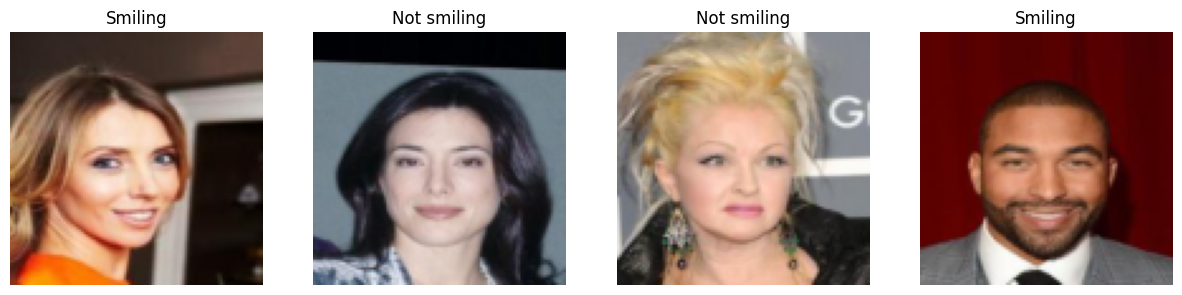

In [6]:
import matplotlib.pyplot as plt
import random
import numpy as np

plt.figure(figsize=(15,15)) 

for i in range(4):
    
    # Get a random sample
    random_sample = random.randint(0, len(train_data)-1)

    # Get the image and its corresponding label
    image, label = train_data.__getitem__(random_sample)

    # Plot the sample
    plt.subplot(1,4,i+1)   
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.title('Smiling' if label == 1 else 'Not smiling')

plt.show()


Let us use PyTorch to implement our version of the `LeNet5` network, which we call `LeNNon`. If you are still getting familiar with PyTorch, check out our [`Machine Learning Intro Course`](https://github.com/Nkluge-correa/teeny-tiny_castle/tree/master/ML%20Intro%20Course).

In [7]:
import torch.nn as nn

class LeNNon(nn.Module):
    def __init__(self):
        """ Define a CNN architecture used for image classification.
            This class defines the LeNNy architecture as a PyTorch module
        """
        super(LeNNon, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 25 * 25, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        """
        Perform a forward pass through the LeNNon architecture.

        This method applies the convolutional layers, max pooling layers,
        and fully connected layers to the input tensor x.

        Parameters:
        -----------
        x (torch.Tensor): The input tensor.

        Returns:
        --------
        torch.Tensor: The output tensor.
        """
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 25 * 25)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
   
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LeNNon()

model = model.to(device)

display(model)

LeNNon(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=20000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Below, we will create data loader objects (`torch.utils.data.DataLoader`). In PyTorch, they are used for loading data from a dataset during the training, validation, and testing phases. Using data loaders, we can efficiently load large datasets, randomly shuffle the data, and batch the data.

In [8]:
batch_size = 256

trainLoader = torch.utils.data.DataLoader(train_data,batch_size=batch_size, shuffle=True)
testLoader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
valLoader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

If everything was done accordingly, our CNN should train smoothly. 😎

If you do not wish to train this model, download [the trained version on this link](https://drive.google.com/uc?export=download&id=1XLuX_qz6vUmwSXVORXaP9PmkqWLMy417), or follow the instructions in our `models` folder.

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    # Training
    train_loss = 0
    train_acc = 0
    model.train()
    for images, labels in trainLoader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_acc += (predicted == labels).sum().item()

    train_loss /= len(trainLoader)
    train_acc /= len(trainLoader.dataset)

    # Validation
    val_loss = 0
    val_acc = 0
    model.eval()
    with torch.no_grad():
        for images, labels in valLoader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_acc += (predicted == labels).sum().item()

    val_loss /= len(valLoader)
    val_acc /= len(valLoader.dataset)
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print(f'Final Validation Accuracy: ' + '{:.2f}' .format(100 * val_acc)+'%', 'Final Validation Loss: ' + '{:.4f}'.format(val_loss))
torch.save(model, 'LeNNon_smile_detector.pt')

Epoch [5/20], Train Loss: 0.1815, Train Acc: 0.9233, Val Loss: 0.1933, Val Acc: 0.9180
Epoch [10/20], Train Loss: 0.1375, Train Acc: 0.9430, Val Loss: 0.2144, Val Acc: 0.9163
Epoch [15/20], Train Loss: 0.0556, Train Acc: 0.9794, Val Loss: 0.3551, Val Acc: 0.9090
Epoch [20/20], Train Loss: 0.0161, Train Acc: 0.9946, Val Loss: 0.6397, Val Acc: 0.9056
Final Validation Accuracy: 90.56% Final Validation Loss: 0.6397


Now let us load our trained model, evaluate it on the testing portion of our split with `20.260 images` and plot the confusion matrix.

In [2]:
import torch
import torch.nn as nn

class LeNNon(nn.Module):
    def __init__(self):
        """ Define a CNN architecture used for image classification.
            This class defines the LeNNy architecture as a PyTorch module
        """
        super(LeNNon, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 25 * 25, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        """
        Perform a forward pass through the LeNNon architecture.

        This method applies the convolutional layers, max pooling layers,
        and fully connected layers to the input tensor x.

        Parameters:
        -----------
        x (torch.Tensor): The input tensor.

        Returns:
        --------
        torch.Tensor: The output tensor.
        """
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 25 * 25)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = torch.load('models/LeNNon_smile_detector.pt')
model.eval()

LeNNon(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=20000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
from sklearn.metrics import confusion_matrix
import plotly.express as px

correct = 0
total = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for data in testLoader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

print('Accuracy on the test images: %d %%' % (100 * correct / total))

# Calculate the confusion matrix

# Put the model into cuda
model = model.to(device)
matrix_test = confusion_matrix(true_labels, predicted_labels)

fig = px.imshow(matrix_test,
                labels=dict(x="Predicted", y="True label"),
                x=['Smiling', 'Not Smiling'],
                y=['Smiling', 'Not Smiling'],
                text_auto=True
                )
fig.update_xaxes(side='top')
fig.update_layout(template='plotly_dark',
                  title='Confusion Matrix',
                  coloraxis_showscale=False,
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  plot_bgcolor='rgba(0, 0, 0, 0)')
fig.show()

To further evaluate `LeNNon`, let us plot the images together with their corresponding labels and predictions. By doing so, we can visually inspect the model's performance. 

> Note: `[1]` = `smiling` and `[0]` = `not_smiling`.

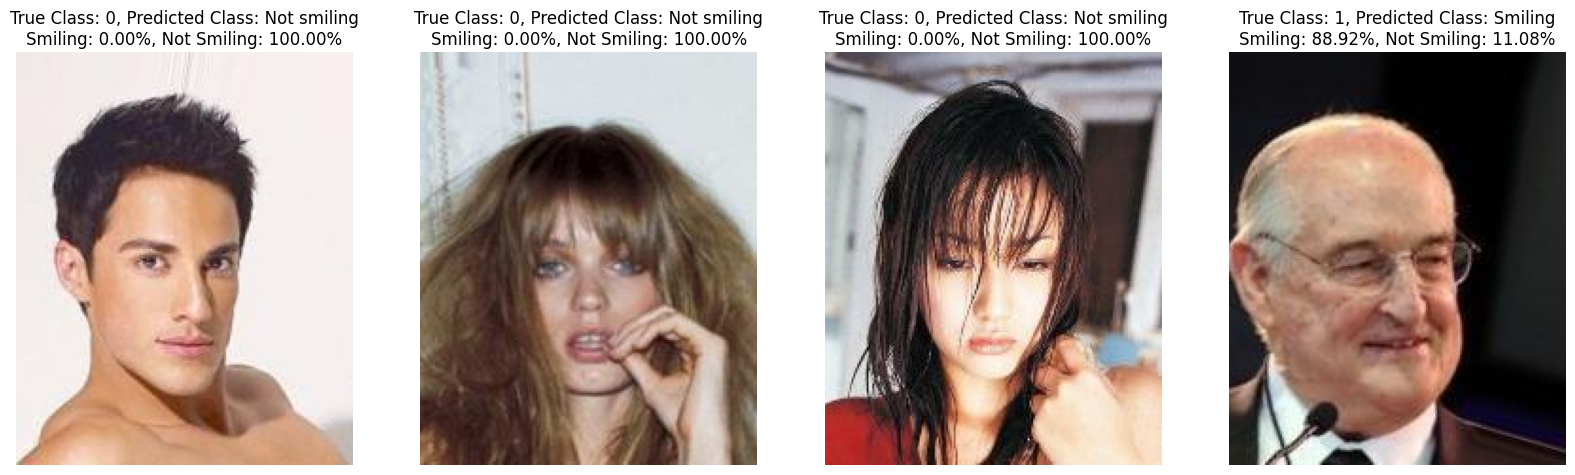

In [14]:
import random
import matplotlib.pyplot as plt

# Select a random subset of images to plot
subset_indices = random.sample(range(len(test_df)), 4)

plt.figure(figsize=(20, 20))

for i, idx in enumerate(subset_indices):
    # Load and preprocess the image
    image_path = f"{IMG_PATH}/{test_df.iloc[idx]['image_id']}"
    image = Image.open(image_path)
    tensor = transform(image).unsqueeze(0)

    # Make a prediction
    with torch.no_grad():
        output = model(tensor)

    # Apply softmax to get probabilities
    probabilities = torch.softmax(output, dim=1)
    percent_smiling = probabilities[0][1].item() * 100
    percent_not_smiling = probabilities[0][0].item() * 100

    # Extract the predicted class
    _, predicted = torch.max(output.data, 1)

    # Plot the samples
    plt.subplot(1, 4, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('True Class: {}, Predicted Class: {}\nSmiling: {:.2f}%, Not Smiling: {:.2f}%'.format(
        test_df.iloc[idx]['Smiling'],
        'Smiling' if predicted.item() == 1 else 'Not smiling',
        percent_smiling,
        percent_not_smiling
    ))

plt.show()


Now, let us evaluate our model's performance on two groups of people with different sensitive attributes: `age`. We want to measure any disparities in treatment or model output for these groups. To do this, we can use statistical metrics of fairness, a set of measures that allow us to detect the presence of bias in our model. These metrics can help us identify any unfair treatment of certain groups and provide insight into how to improve the fairness of our models. For more examples of how to work with fairness metrics, check these other tutorials:

- [Creating Ceteris-paribus Profiles with the COMPAS dataset](https://github.com/Nkluge-correa/teeny-tiny_castle/blob/12eeb87cbb2abfa66c518c40785c47cdb6b62978/ML%20Fairness/ceteris_paribus_profiles.ipynb).
- [Removing Fairness Bias with the DisparateImpactRemover](https://github.com/Nkluge-correa/teeny-tiny_castle/blob/12eeb87cbb2abfa66c518c40785c47cdb6b62978/ML%20Fairness/disparate_impact_remove_Hogwarts.ipynb).
- [Measuring Fairness Metrics with the Credit Card Dataset](https://github.com/Nkluge-correa/teeny-tiny_castle/blob/12eeb87cbb2abfa66c518c40785c47cdb6b62978/ML%20Fairness/fair_metrics_Credit_card_approval.ipynb).
- [Measuring Fairness Metrics with the Adult Census Dataset](https://github.com/Nkluge-correa/teeny-tiny_castle/blob/12eeb87cbb2abfa66c518c40785c47cdb6b62978/ML%20Fairness/fairness_income.ipynb).

_Fairness metrics are a set of measures that enable you to detect the presence of bias in your model._ For a full review of the most prominent definitions of fairness in algorithmic classification, we recommend [_Fairness Definitions Explained_](https://fairware.cs.umass.edu/papers/Verma.pdf). Below you will see how to apply these definitions in code.

First, we generate the confusion matrix for every sub-group (usually referred to as "privileged" and "unprivileged") we wish to measure.

![confusion-matrix](https://upload.wikimedia.org/wikipedia/commons/3/32/Binary_confusion_matrix.jpg)

- $TP$: True Positive - correctly predicted positives (predicted `smiling` and it was `smiling`).
- $FP$: False Positive - correctly predicted negatives (predicted `not smiling` and it was `not smiling`).
- $TN$: True Negative - incorrectly predicted positives (predicted `smiling` and it was `not smiling`).
- $FN$: False Negative - incorrectly predicted negatives (predicted `not smiling` and it was `smiling`).

Having these values $(TP, FP, TN, FN)$ statistical fairness metrics can be calculated. Let us apply these metrics to check for any age bias in our model. For this, we will split our `test_df` file into  two groups: Group A: `young` and Group B: `not_young`.

In [10]:
from torch.utils.data import DataLoader

# separate the test dataset into two datasets: 
# one with the "young" label and one with the "not_young" label
young = test_df[test_df["Young"] == 1]
not_young = test_df[test_df["Young"] != 1]

# how many images are in each dataset?
print("Images that have the 'young' label: ",len(young))
print("Images that have the 'not_young' label: ",len(not_young))

# create a dataset for each of the two datasets
test_young = Dataset(young, IMG_PATH, transform)
test_not_young = Dataset(not_young, IMG_PATH, transform)

# create a dataloader for each of the two datasets
loader_young = DataLoader(test_young, batch_size=64)
loader_not_young = DataLoader(test_not_young, batch_size=64)


Images that have the 'young' label:  15672
Images that have the 'not_young' label:  4588


Now we will evaluate the performance of our trained model against the separated groups of `young` and `not_young`. First, we need to construct a confusion matrix for each group.

In [11]:
import plotly.express as px

# Put the model into cuda
model = model.to(device)

# Define a function to make predictions on the test data
def make_predictions(test_loader):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true += labels.tolist()
            y_pred += predicted.tolist()
    return y_true, y_pred

# Make predictions on the two test datasets
y_true_young, y_pred_young = make_predictions(loader_young)
y_true_not_young, y_pred_not_young = make_predictions(loader_not_young)

# Compute the confusion matrices
matrix_young = confusion_matrix(y_true_young, y_pred_young)
matrix_not_young = confusion_matrix(y_true_not_young, y_pred_not_young)

# Plot the confusion matrices
class_names = ['not_smiling', 'smiling'] 

fig = px.imshow(matrix_young,
                labels=dict(x="Predicted", y="True label"),
                x=class_names,
                y=class_names,
                text_auto=True
                )
fig.update_xaxes(side='top')
fig.update_layout(template='plotly_dark',
                  title='Confusion Matrix for only the "young" label',
                  coloraxis_showscale=False,
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  plot_bgcolor='rgba(0, 0, 0, 0)')
fig.show()

fig = px.imshow(matrix_not_young,
                labels=dict(x="Predicted", y="True label"),
                x=class_names,
                y=class_names,
                text_auto=True
                )
fig.update_xaxes(side='top')
fig.update_layout(template='plotly_dark',
                  title='Confusion Matrix for only the "not_young" label',
                  coloraxis_showscale=False,
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  plot_bgcolor='rgba(0, 0, 0, 0)')
fig.show()

Given that we have the confusion matrix values $(TP, FP, TN, FN)$, we can calculate all known statistical fairness metrics we want.

In [12]:
def calc_fair(ground_truth_priv, predictions_priv, ground_truth_unpriv, predictions_unpriv):
    """
    The function calc_fair computes several fairness metrics for a given machine 
    learning model on a test set DataFrame. The fairness metrics calculated include 
    statistical parity ratio, true positive rate, positive predictive value, 
    false positive rate, accuracy, equal opportunity ratio, predictive parity 
    ratio, predictive equality ratio, and accuracy equality ratio. The function 
    takes in the following arguments:

    Args:
    --------
        - model: The trained machine learning model to evaluate fairness on.
        - DataFrame: The test set data used to evaluate the model.
        - protected_attribute: The name of the protected attribute in the DataFrame.
        - group_priv: The value of the protected attribute for the privileged group.
        - group_unpriv: The value of the protected attribute for the unprivileged group.
        - label: The name of the column in the DataFrame that contains the ground truth labels.
    
    Returns:
    --------
    The function returns a dictionary containing the fairness metric names and their 
    corresponding scores. The scores are rounded to two decimal places. Additionally, 
    the function returns the equalized odds as a string.
    """

    TN_PV, FP_PV, FN_PV, TP_PV = confusion_matrix(ground_truth_priv, predictions_priv).ravel()
    TN_UPV, FP_UPV, FN_UPV, TP_UPV = confusion_matrix(ground_truth_unpriv, predictions_unpriv).ravel()

    statistical_parity_priv = (TP_PV + FP_PV)/(TP_PV + FP_PV + TN_PV + FN_PV)  # STATISTICAL PARITY RATIO
    statistical_parity_unpriv = (TP_UPV + FP_UPV)/(TP_UPV + FP_UPV + TN_UPV + FN_UPV)  # STATISTICAL PARITY RATIO
    equal_oportunity_priv = TP_PV / (TP_PV+FN_PV)  # TRUE POSITIVE RATIO
    equal_oportunity_unpriv = TP_UPV / (TP_UPV+FN_UPV)  # TRUE POSITIVE RATIO
    predictive_parity_priv = TP_PV/(TP_PV + FP_PV)  # POSITIVE PREDICTIVE VALUE
    predictive_parity_unpriv = TP_UPV/(TP_UPV + FP_UPV)  # POSITIVE PREDICTIVE VALUE
    predictive_equality_priv = FP_PV / (FP_PV+TN_PV)  # FALSE POSITIVE RATE
    predictive_equality_unpriv = FP_UPV / (FP_UPV+TN_UPV)  # FALSE POSITIVE RATE
    accuracy_equality_priv = (TP_PV + TN_PV)/(TP_PV + FP_PV + TN_PV + FN_PV)  # ACCURACY EQUALITY RATIO
    accuracy_equality_unpriv = (TP_UPV + TN_UPV)/(TP_UPV + FP_UPV + TN_UPV + FN_UPV)  # ACCURACY EQUALITY RATIO 

    if statistical_parity_priv >= statistical_parity_unpriv:
        statistical_parity_ratio = statistical_parity_unpriv/statistical_parity_priv
    elif statistical_parity_priv < statistical_parity_unpriv:
        statistical_parity_ratio = statistical_parity_priv/statistical_parity_unpriv

    if equal_oportunity_priv >= equal_oportunity_unpriv:
        equal_oportunity_ratio = equal_oportunity_unpriv/equal_oportunity_priv
    elif equal_oportunity_priv < equal_oportunity_unpriv:
        equal_oportunity_ratio = equal_oportunity_priv/equal_oportunity_unpriv
    
    if predictive_parity_priv >= predictive_parity_unpriv:
        predictive_parity_ratio = predictive_parity_unpriv/predictive_parity_priv
    elif predictive_parity_priv < predictive_parity_unpriv:
        predictive_parity_ratio = predictive_parity_priv/predictive_parity_unpriv

    if predictive_equality_priv >= predictive_equality_unpriv:
        predictive_equality_ratio = predictive_equality_unpriv/predictive_equality_priv
    elif predictive_equality_priv < predictive_equality_unpriv:
        predictive_equality_ratio = predictive_equality_priv/predictive_equality_unpriv
    
    if accuracy_equality_priv >= accuracy_equality_unpriv:
        accuracy_equality_ratio = accuracy_equality_unpriv/accuracy_equality_priv
    elif accuracy_equality_priv < accuracy_equality_unpriv:
        accuracy_equality_ratio = accuracy_equality_priv/accuracy_equality_unpriv

    data = {'Fairness Metrics': ['Chance of receiving the positive class - privileged',
                                'Chance of receiving the positive class - unprivileged',
                                'Statistical Parity Ratio (SPR)',
                                'True Positive Rate - privileged',
                                'True Positive Rate - unprivileged',
                                'Equal Opportunity Ratio (EOR)',
                                'Positive Predictive Value - privileged',
                                'Positive Predictive Value - unprivileged',
                                'Predictive Parity Ratio (PPR)',
                                'False Positive Rate - privileged',
                                'False Positive Rate - unprivileged',
                                'Predictive Equality Ratio (PER)',
                                'Accuracy - privileged',
                                'Accuracy - unprivileged',
                                'Accuracy Equality Ratio (AER)',
                                'Equalized Odds'],
            'Scores': [round(statistical_parity_priv, 2),
                        round(statistical_parity_unpriv, 2),
                        round(statistical_parity_ratio,2),
                        round(equal_oportunity_priv, 2),
                        round(equal_oportunity_unpriv, 2),
                        round(equal_oportunity_ratio, 2),
                        round(predictive_parity_priv,2),
                        round(predictive_parity_unpriv,2),
                        round(predictive_parity_ratio,2),
                        round(predictive_equality_priv,2),
                        round(predictive_equality_unpriv,2),
                        round(predictive_equality_ratio,2),
                        round(accuracy_equality_priv,2),
                        round(accuracy_equality_unpriv,2),
                        round(accuracy_equality_ratio,2),
                        f'TPR: {round(equal_oportunity_priv, 2)} vs {round(equal_oportunity_unpriv, 2)}. FPR: {round(predictive_equality_priv,2)} vs {round(predictive_equality_unpriv,2)}']
            }
    return pd.DataFrame(data).set_index('Fairness Metrics')

from IPython.display import Markdown

fairness_df = calc_fair(y_true_young, y_pred_young, y_true_not_young, y_pred_not_young)
display(Markdown(fairness_df.to_markdown()))

| Fairness Metrics                                      | Scores                               |
|:------------------------------------------------------|:-------------------------------------|
| Chance of receiving the positive class - privileged   | 0.46                                 |
| Chance of receiving the positive class - unprivileged | 0.51                                 |
| Statistical Parity Ratio (SPR)                        | 0.9                                  |
| True Positive Rate - privileged                       | 0.89                                 |
| True Positive Rate - unprivileged                     | 0.89                                 |
| Equal Opportunity Ratio (EOR)                         | 1.0                                  |
| Positive Predictive Value - privileged                | 0.92                                 |
| Positive Predictive Value - unprivileged              | 0.9                                  |
| Predictive Parity Ratio (PPR)                         | 0.97                                 |
| False Positive Rate - privileged                      | 0.07                                 |
| False Positive Rate - unprivileged                    | 0.11                                 |
| Predictive Equality Ratio (PER)                       | 0.62                                 |
| Accuracy - privileged                                 | 0.91                                 |
| Accuracy - unprivileged                               | 0.89                                 |
| Accuracy Equality Ratio (AER)                         | 0.98                                 |
| Equalized Odds                                        | TPR: 0.89 vs 0.89. FPR: 0.07 vs 0.11 |

Fairness metrics can help us determine if our model discriminates according to any particular definition of fairness. However, as an [impossibility theorem](https://arxiv.org/abs/2007.06024), some Fairness metrics (SPR, EOR, PPR) are incompatible and cannot be completely satisfied simultaneously. Thus, the choice of which metric to use must be made according to the context of an application (i.e., benefit awarding, medical diagnosis, etc.).

Overall, we see that the model achieved a testing accuracy of `90%`. Meanwhile, the calculated fairness metrics seem quite balanced, except for the _Predictive Equality Ratio_. For example, this model has a False Positive Rate that makes `not_young` samples classified as `smiling`, even though they are not smiling, with more frequency. Given that our classifier was developed for an innocuous application, that may not be a vital flaw. 

However, if our model was detecting `police fugitives`, and these rates remained, this would mean that older persons would have a more significant chance (4% increase) of being incorrectly classified as a fugitive. This helps us remember that fairness and AI risks are contextual and should be evaluated/interpreted under the specific domain an application will operate.

---

Return to the [Castle](https://github.com/Nkluge-correa/teeny-tiny_castle)